In [2]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] == 0):
            mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()
    
    
def acc_number_eval(nbr_eval, best_fit):
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            return acc_nbr_eval, ne
        
def fitness_per_descriptor(descriptors,fitnesses):
    fit_per_desc = [dict() for _ in range(int(len(fitnesses)/20))]
    for fit,desc in zip(fitnesses,descriptors):
        if(fit[0] == desc[0] and fit[1] == desc[1]):
            organ_desc = str(int(desc[6]*16))+str(int(desc[7]*16)) + str(int(desc[8]*16))
            if(organ_desc in fit_per_desc[fit[0]]):
                fit_per_desc[fit[0]][organ_desc].append(fit[2])
            else:
                fit_per_desc[fit[0]][organ_desc] = [fit[2]]
    return fit_per_desc

def best_desc_per_gen(descriptors,fitnesses):
    best_fit = 0
    best_idx = 0
    best_desc = []
    for fit,i in zip(fitnesses,range(len(fitnesses))):
        if(fit[1] == 0 and fit[0] != 0):
            best_fit = 0
            best_desc.append([fit[0]-1,int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
        if(fit[2] > best_fit):
            best_fit = fit[2]
            best_idx = i

    return best_desc
                     

In [3]:
arena="Hard Race 2"

In [4]:
exp_folder = "/home/leni/are-logs/mnipes_hard_refreshed/"

In [5]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    #acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=0
        for i,line in ctrl_arch.iterrows():
            ctrl_fit+=line["fitness"]
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit/nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    #print(acc_nbr_eval[-1])

    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    
    for gen, bf, af, nc,cf,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,ctrl_fit_v,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,nc,cf,ne,np.mean(lp),np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","number of controllers","average fitness in controller archive","number of evaluations","average learning progress","best learning progress"])

mnipes_22_3_15-46-19-9556-564896556
40
mnipes_22_3_15-49-43-3299-1195692820
40
mnipes_22_3_15-49-24-4354-2618967957
40
mnipes_22_3_15-46-14-4913-1217548156
40
mnipes_22_3_15-45-52-2920-601342095
40
mnipes_22_3_15-46-0-167-147830687
40
mnipes_22_3_15-49-6-6243-2942441300
40
mnipes_22_3_15-46-0-76-3473838169
40
mnipes_22_3_15-49-26-6374-3197865617
40
mnipes_22_3_15-45-48-8921-2163882586
40


(0.6, 1)

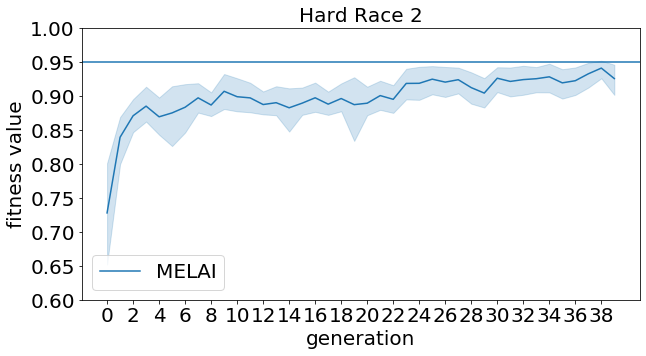

In [6]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_c_data,x="generation",y="best fitness",label="MELAI")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.6,1])

In [7]:
fit_lines = []
for folder in os.listdir(exp_folder):
    fit_lines += load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
fit_data = pd.DataFrame(data=fit_lines,columns=["generation","individual","fitness"])
morph_lines = []

for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    for desc in descriptors:
        morph_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
print(len(lines))
morph_data = pd.DataFrame(data=morph_lines,columns=["gen","robot","wheel","sensor","joint"])
morph_data = pd.concat([morph_data,fit_data],axis=1,join="inner")
wheels = [0 for _ in range(15)]
joints = [0 for _ in range(15)]
sensors = [0 for _ in range(15)]

total=0
for row in morph_data.iterrows():
    if(row[1]["fitness"] >= 0.95):
        wheels[int(row[1]["wheel"])]+=1
        joints[int(row[1]["joint"])]+=1
        sensors[int(row[1]["sensor"])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100

organ_lines = []
for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","200"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","200"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","200"])

FileNotFoundError: [Errno 2] No such file or directory: '/home/leni/are-logs/mnipes_hard_refreshed/mnipes_22_3_15-46-19-9556-564896556/MD_Cart_WDH.csv'

In [7]:
arena="Two rooms 2"

In [8]:
exp_folder = "/home/leni/are-logs/mnipes_rooms_refreshed/"

In [9]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    print(len(best_fit))
    nbr_eval = load_number_of_eval_per_gen(exp_folder + folder,len(best_fit))
    #acc_nbr_eval,bff_ne = acc_number_eval(nbr_eval, best_fit)
    nbr_ctrl_v = []
    ctrl_fit_v = []
    gen_v = []
    for file in os.listdir(exp_folder + folder):
        if(file.split("_")[0] != "controller"):
            continue
        gen_v.append(float(file.split("archive")[-1]))
        ctrl_arch = load_controller_archive(exp_folder + folder + "/" + file)
        nbr_ctrl=0
        ctrl_fit=0
        for i,line in ctrl_arch.iterrows():
            ctrl_fit+=line["fitness"]
            if(line["fitness"] > 0):
                nbr_ctrl+=1
        nbr_ctrl_v.append(nbr_ctrl)
        ctrl_fit_v.append(ctrl_fit/nbr_ctrl)
    nbr_ctrl_v = [nbr_ctrl_v[i] for i in np.argsort(gen_v)]
    #print(acc_nbr_eval[-1])

    best_f, init_f, learn_delta, learn_prog = load_controllers_fitnesses(exp_folder + folder + "/",len(best_fit))
    
    for gen, bf, af, nc,cf,ne,lp in zip(range(len(best_fit)),best_fit,avg_fit,nbr_ctrl_v,ctrl_fit_v,nbr_eval,learn_delta):
        lines.append([gen,gen*2000,bf,af,nc,cf,ne,np.mean(lp),np.max(lp)])
wa_c_data = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness","number of controllers","average fitness in controller archive","number of evaluations","average learning progress","best learning progress"])

mnipes_22_3_15-46-53-3024-3062802934
40
mnipes_22_3_15-47-7-7984-1207571973
40
mnipes_22_3_15-46-54-4043-3316156953
40
mnipes_22_3_15-47-14-4979-2089017903
40
mnipes_22_3_15-46-53-3810-3047569683
40
mnipes_22_3_15-47-4-4261-386821379
40
mnipes_22_3_15-46-56-6015-1414734475
40
mnipes_22_3_15-47-21-1263-830636640
40
mnipes_22_3_15-46-48-8481-1851147076
40
mnipes_22_3_15-47-0-177-2730317195
40


(0.75, 1)

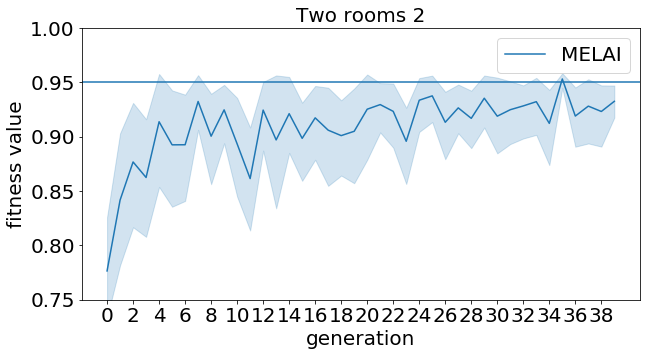

In [10]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=wa_c_data,x="generation",y="best fitness",label="MELAI")
ax.axhline([0.95])
ax.set_ylabel("fitness value")
ax.set_xticks(range(0,40,2))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
ax.set_ylim([0.75,1])